In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Thu Nov 22 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.1
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.9.0-7-amd64
machine    : x86_64
processor  : 
CPU cores  : 12
interpreter: 64bit


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
eeg_signals = np.transpose(data.values)

Opening raw data file /home/kovar/thesis_project/data/processed/1a.fif...
This filename (/home/kovar/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


<ipython-input-2-1d393a8a483f>:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


In [ ]:
from lib.nolitsa.nolitsa import lyapunov, data, dimension, delay, noise, d2, utils
from lib.nolds.nolds.measures import corr_dim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

taus = [1]
dims = [15]
windows = [50]
maxt = 13
maxtau = 20
# sampl_period = 1/250
sampl_period = 1
R = 3.0
A = 1.0

def localmin(x):
     return (np.diff(np.sign(np.diff(x))) > 0).nonzero()[0] + 1
    
def localmax(x):
     return (np.diff(np.sign(np.diff(x))) < 0).nonzero()[0] + 1
    
def compute_lyaps(x, dims, tau, window):
    res = lyapunov.mle_embed(x, dim=dims, tau=tau, window=window, maxnum=2*window+3)
    lyaps = []
    for re in res:
        poly = np.polyfit(np.arange(len(re)), re, 1)
        l = poly[0] / sampl_period
        lyaps.append(l)
    return lyaps


def plot_divergence(x, tau, window, found_dim):
    plotted_dims = dims + [found_dim]
    d = lyapunov.mle_embed(x, dim=plotted_dims, tau=tau, maxt=maxt)
    t = np.arange(maxt)
    
    plt.figure(figsize=(15,5))
    
    plt.title(rf'Average divergence: $\tau={tau}$ tsep={window}')
    plt.xlabel(r'$i$')
    plt.ylabel(r'Average divergence $\langle d_j(i) \rangle$')
    plt.ylim([0, 3.8])
    plt.xlim([0, maxt])
    for dd, dim in zip(d, plotted_dims):
        poly = np.polyfit(np.arange(len(dd)), dd, 1)
        l = poly[0] / sampl_period
        plt.plot(t, dd, '-', label=r'm={}: $\lambda_1={:.3f}$'.format(dim, l))
        plt.plot(t, np.polyval(poly, t), '--', color='grey', alpha=0.5)
    plt.legend()
     
    plt.show()

def plot_fnn_afn(x, tau, window):
    fnn_dims = np.arange(1, 11)
    afn_dims = np.arange(1, 20)
    f1, f2, f3 = dimension.fnn(x, R=R, A=A, tau=tau, dim=fnn_dims, window=window, metric='euclidean')
    
    E, Es = dimension.afn(x, tau=tau, dim=afn_dims, window=window, metric='euclidean')
    E1, E2 = E[1:] / E[:-1], Es[1:] / Es[:-1]

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title(f'FNN')
    plt.xlabel(r'Embedding dimension')
    plt.ylabel(r'FNN (%)')
    plt.plot(fnn_dims, 100 * f1, 'bo--', label=r'Test I')
    plt.plot(fnn_dims, 100 * f2, 'g^--', label=r'Test II')
    plt.plot(fnn_dims, 100 * f3, 'rs-', label=r'Test I + II')
    plt.legend()
    
    plt.subplot(122)
    plt.title(r'AFN')
    plt.xlabel(r'Embedding dimension $m$')
    plt.ylabel(r'$E_1(m)$ and $E_2(m)$')
    plt.plot(afn_dims[:-1], E1, 'bo-', label=r'$E_1(d)$')
    plt.plot(afn_dims[:-1], E2, 'go-', label=r'$E_2(d)$')
    plt.legend()

    plt.show()
    
    return np.argmin(f3)+1

    
def plot_corr_dim(x):
    plt.figure()
    plt.title(r'$D_2$ vs. embedding dimension')
    plt.xlabel(r'Embedding dimension')
    plt.ylabel(r'$D_2$')
    corr_dims = []
    dims = np.arange(1, 15)
    for dim in dims:
        corr_dims.append(corr_dim(x, emb_dim=dim))
    found_m = localmax(dims)+1
    if len(found_m) > 0:
        plt.plot(dims, corr_dims, found_m, corr_dims[found_m], 'o')
    else:
        plt.plot(dims, corr_dims)
    
def plot_lyap(x, tau, window):
    plt.figure()
    plt.title(r'$\lambda_1$ vs. embedding dimension')
    plt.xlabel(r'Embedding dimension')
    plt.ylabel(r'$\lambda_1$')
    dims = np.arange(1, 15)
    lyaps = compute_lyaps(x, dims, tau, window)
    plt.plot(dims, lyaps)
    
    plt.show()
    
def plot_acorr_mi(x, chan_num):
    r = delay.acorr(x, maxtau=maxtau)
    i = delay.dmi(x, maxtau=maxtau)
    tri = np.arange(maxtau)
    i_delay = localmin(i) + 1
    r_delay = np.argmax(r < (1 - 1.0 / np.e))
    found_delays = (i_delay[0], r_delay,) if len(i_delay) > 0 else (r_delay,)
     
    plt.show()
    
    plt.figure(1)
    
    plt.subplot(211)
    plt.title(r'Delay estimation')
    plt.xlabel(r'Time delay $\tau$')
    plt.ylabel(r'DMI')
    plt.plot(tri, i, i_delay, i[i_delay], 'o')

    plt.subplot(212)
    plt.xlabel(r'Time delay $\tau$')
    plt.ylabel(r'Autocorrelation')
    plt.plot(tri, r, r_delay, r[r_delay], 'o')

    f = plt.figure(figsize=(15,5))
    
    def plot_time_delay(td, ax):
        plt.title(r'Time delay = %d' % td)
        # plt.xlabel(r'$x(t)$')
        # plt.ylabel(r'$x(t + \tau)$')
        ax.plot(xs=x[:-2*td], ys=x[td:-td], zs=x[2*td:])
    
    for i, d in enumerate((1,2,3) + found_delays):
        ax = f.add_subplot(2,3, i+1, projection='3d', label='label')
        plot_time_delay(d, ax)
        
    plt.show()
    
    # return found_delays
    return r_delay

def plot(eeg_signals):
    for chan_num, chan_data in enumerate(eeg_signals):
        print(f'CHANNEL {chan_num}')
        plt.figure(figsize=(15,5))
        plt.title(f'Channel {chan_num}')
        plt.xlabel(r'Time step')
        plt.plot(chan_data)
        r_delay = plot_acorr_mi(chan_data, chan_num)
        # plot_corr_dim(chan_data)
        for tau in taus + [r_delay]:
            for window in windows:
                print(rf'$\tau={tau}$ tsep={window}')  
                # plot_lyap(chan_data, tau, window)
                found_dim = plot_fnn_afn(chan_data, tau, window)
                plot_divergence(chan_data, tau, window, found_dim)

In [ ]:
plot(eeg_signals)

# Different dataset

In [52]:
file_name = os.path.join(DATA_ROOT, 'alc_exam.csv')
df = pd.read_csv(file_name, sep=' ', names=['trial', 'channel', 't', 'value'],
                 index_col=False, usecols=[1,2,3], skiprows=5)
df = df[df['t'] != 'chan']
df['t'] = df['t'].astype(int)
df = df.pivot(index='t', columns='channel', values='value').sort_index()
alc_eeg_signals = np.transpose(df.values)
df

channel    AF1    AF2     AF7     AF8    AFZ      C1     C2      C3      C4  \
t                                                                             
0       -2.146  1.129 -16.856 -10.020 -0.987  -1.129  2.747  -2.716  -0.926   
1       -2.146  0.641  -7.090  -7.090 -1.475  -1.617 -1.160  -3.204  -2.879   
2       -1.658 -0.336   7.558   1.211 -0.987   0.336  0.305   1.678   2.492   
3       -0.682 -0.824  19.277  10.488 -0.010   0.824  0.305  -0.275   2.981   
4        2.248  0.641  23.183  13.906  2.431   2.777  2.258   4.608   5.910   
5        5.178  3.571  18.789  10.976  4.873   6.683 -2.625  16.327   1.516   
6        6.643  6.012  11.464   5.605  6.826   1.312  2.258   1.190  -0.437   
7        5.178  6.989   6.093   2.675  6.826   2.289 -2.136   0.214  -9.715   
8        1.760  5.524   2.187   2.187  4.384   0.824 -1.648   5.585   0.539   
9       -1.658  2.594  -1.231   2.187  0.966  -0.153 -0.671   3.143  -1.902   
10      -3.611  0.641  -4.649  -1.231 -1.963  10.590 -4.578  25.116 -11.180   
11      -1.658  0.153  -7.090  -6.602 -2.452   1.801 -0.671  -4.669  -5.809   
12       1.272  1.617  -5.625  -9.043 -0.010  -0.641  0.793   0.702   1.516   
13       3.225  3.082  -0.743  -6.114  2.431   2.289 -1.648  19.745  -2.879   
14       2.736  4.059   4.629  -0.254  2.920  -1.617  0.305 -16.876   0.051   
15       0.295  3.571   8.046   5.117  1.943  -1.129 -0.183  -1.740   3.469   
16      -1.658  2.594   7.558   7.070 -0.010   9.613 -5.066  17.792  -6.297   
17      -0.682  2.106   4.629   6.582 -0.498   1.312  0.793  -0.763   2.981   
18       1.760  1.129  -0.254   5.605 -0.498   0.336 -3.113  -4.669 -10.203   
19       3.713 -0.336  -4.161   5.605 -0.010   1.312 -0.671   1.190  -1.902   
20       3.225 -2.289  -5.137   5.117 -0.010  -2.594  3.235  -2.716   6.887   
21       2.248 -2.777  -1.719   3.652 -0.010  -0.153  3.723   5.585  12.746   
22       2.736 -1.312   5.605   1.699  0.478  -0.641 -1.160  -3.204  -0.437   
23       4.690  1.129  13.418   0.722  2.431   6.195 -0.183   6.561 -10.691   
24       6.643  3.082  15.371   1.211  4.384  -2.106  4.211  -9.552   1.027   
25       6.643  4.059  10.000   1.211  4.873  -0.153 -1.648   2.167   0.051   
26       3.225  3.571   0.234  -1.719  3.408  -1.129 -1.160  -1.251  -2.391   
27      -1.658  3.082  -5.137  -7.090  0.478  14.984 -3.113  34.882  -6.297   
28      -4.100  3.571  -2.696 -10.020 -1.475   3.265 -3.113  -3.693  -8.250   
29      -3.123  4.547   5.605  -6.602 -0.987   0.336  0.793   8.514   2.981   
..         ...    ...     ...     ...    ...     ...    ...     ...     ...   
226      5.178  6.989  21.230  21.230  5.361  -2.106  5.188  -7.111   4.934   
227      3.225  8.942  20.742  25.625  5.849   6.195 -0.183  10.468  -1.414   
228      2.248  8.453  15.371  21.718  4.873   4.242  5.188   5.096  10.305   
229      3.225  5.524  10.976  11.953  2.920   4.730  4.211   2.167   8.352   
230      4.201  2.106  10.000   1.211  1.455   3.265  0.793   3.143   2.492   
231      5.666  0.153  11.464  -3.184  0.478  18.402 -2.136  36.835   0.051   
232      6.154 -1.312  13.906  -0.743 -0.498   0.336  4.211  -7.111  -5.809   
233      4.201 -3.265  15.371   5.605 -0.987   7.660 -1.648  13.885  -7.762   
234      2.248 -4.242  16.836   9.023 -0.987   3.265  1.282   9.003  -0.437   
235      0.295 -2.777  15.859   7.558 -0.987  10.590  2.747  23.163   1.027   
236     -0.682  1.129  11.464   3.164 -0.987  -0.641  2.747 -14.435   0.539   
237      0.295  6.012   3.652   1.211 -0.498  -1.129  4.211  -9.064   5.910   
238      1.760  7.965  -4.161   3.652 -0.010   3.754  3.235   7.050   9.328   
239      3.225  6.012  -6.602   9.511 -0.498   7.660  3.235   2.167   5.910   
240      3.713  0.153  -2.207  13.418 -1.475   2.289  0.305   1.190  -9.226   
241      4.201 -4.242   7.558  12.929 -1.475   1.312  4.700  -0.275  11.770   
242      3.225 -4.242  17.812   9.023 -0.987   6.683  2.258   6.073   3.469   
243      2.248  0.153  24.160   7.558 -0.010   2.2

CHANNEL 0


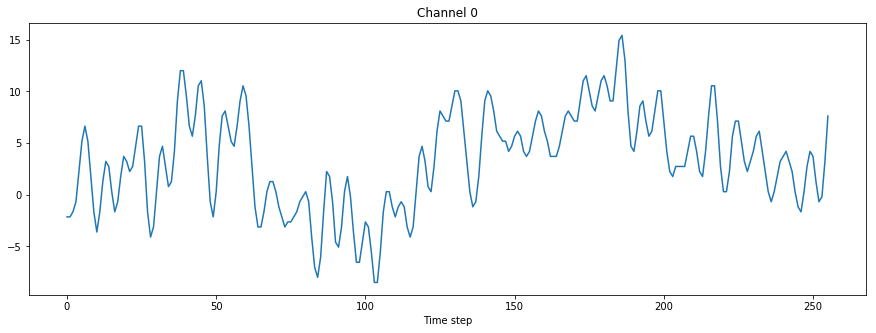

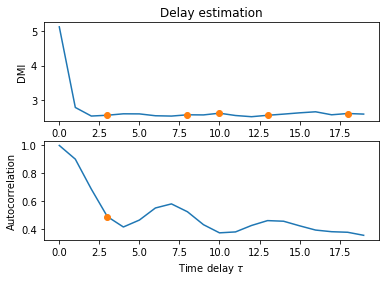

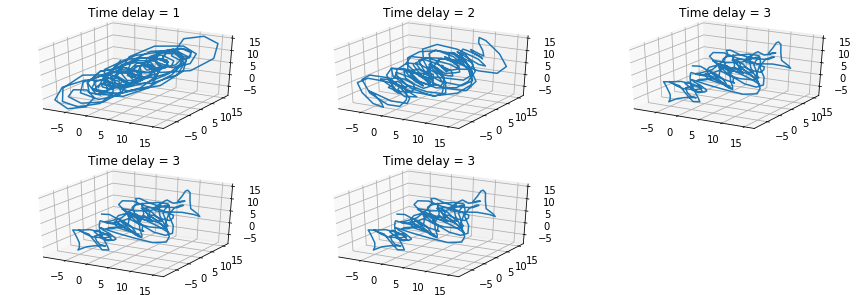

$\tau=1$ tsep=50


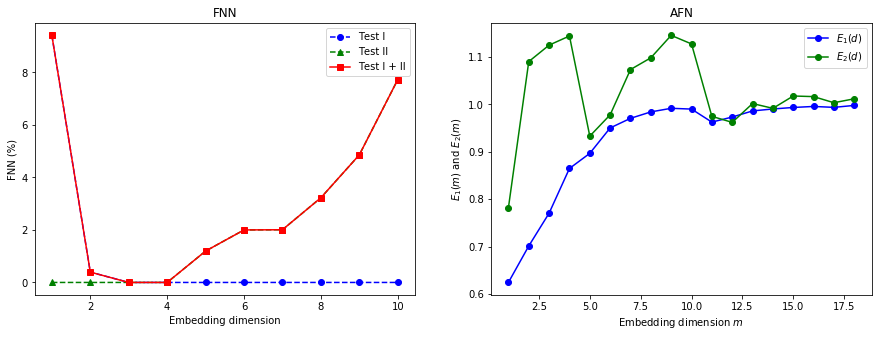

/home/kovar/thesis_project/src/lib/nolitsa/nolitsa/lyapunov.py:75: RuntimeWarning: divide by zero encountered in log
  d[t] = np.mean(np.log(utils.dist(y[t1], y[t2], metric=metric)))


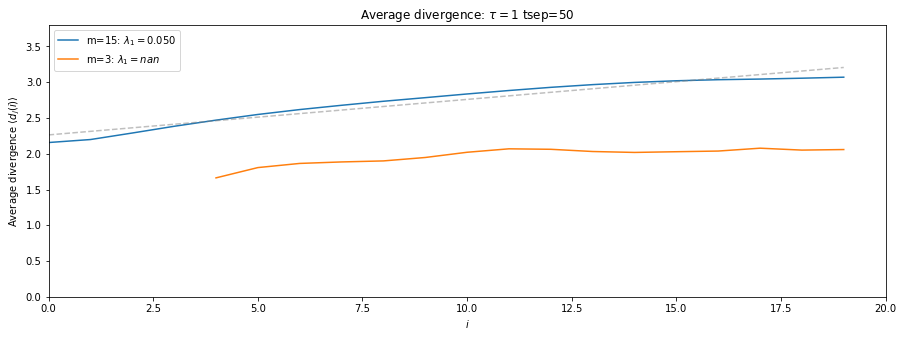

$\tau=3$ tsep=50


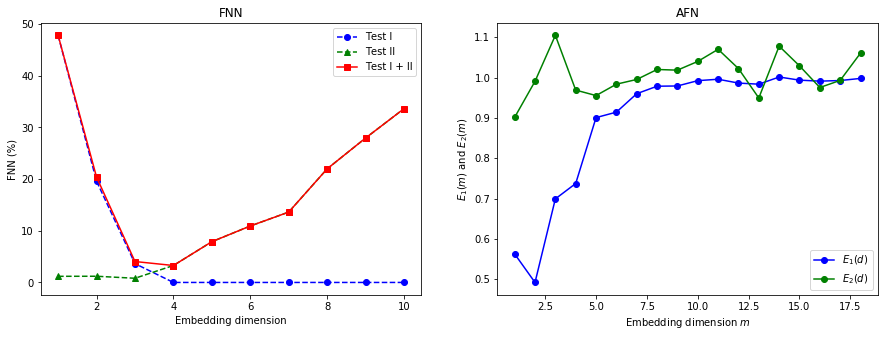

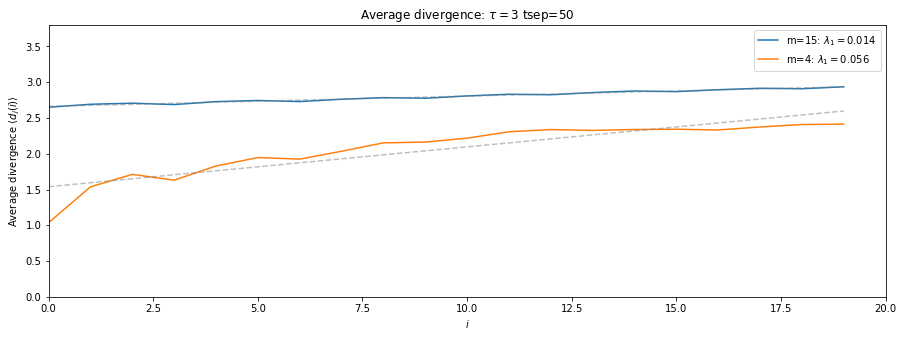

CHANNEL 1


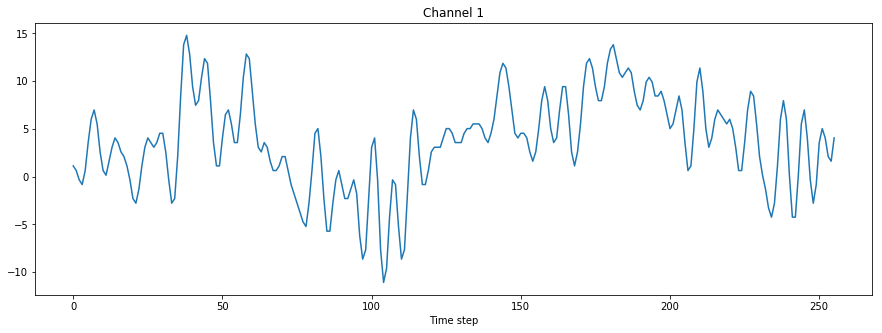

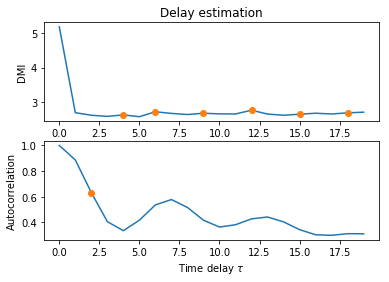

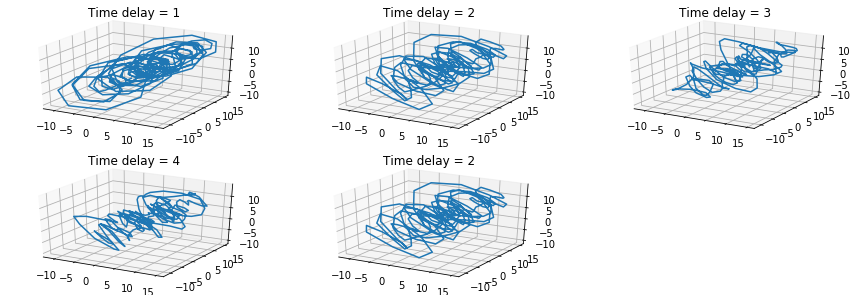

$\tau=1$ tsep=50


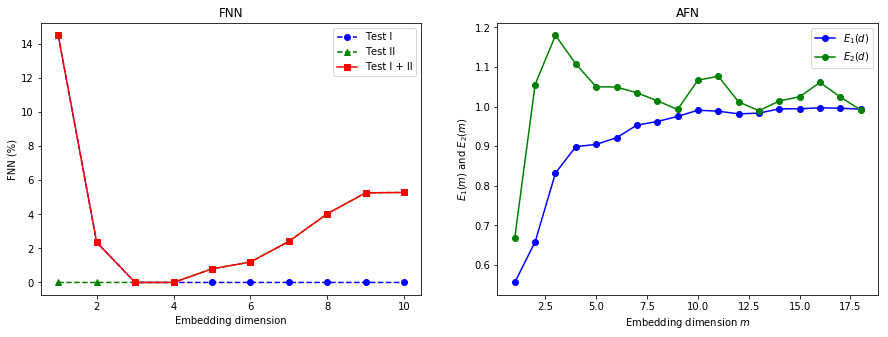

/home/kovar/thesis_project/src/lib/nolitsa/nolitsa/lyapunov.py:75: RuntimeWarning: divide by zero encountered in log
  d[t] = np.mean(np.log(utils.dist(y[t1], y[t2], metric=metric)))


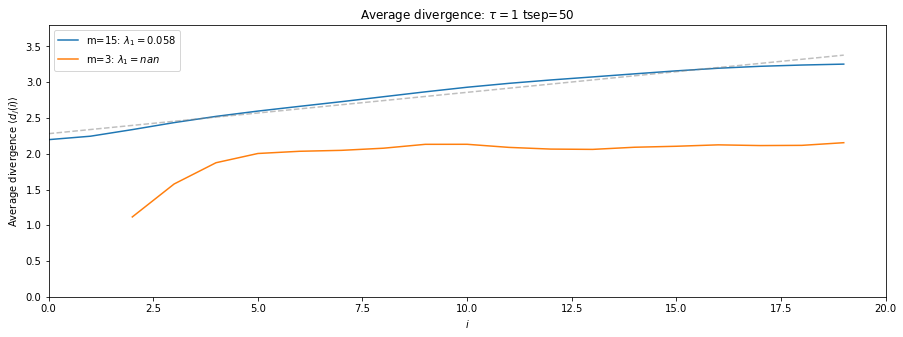

$\tau=2$ tsep=50


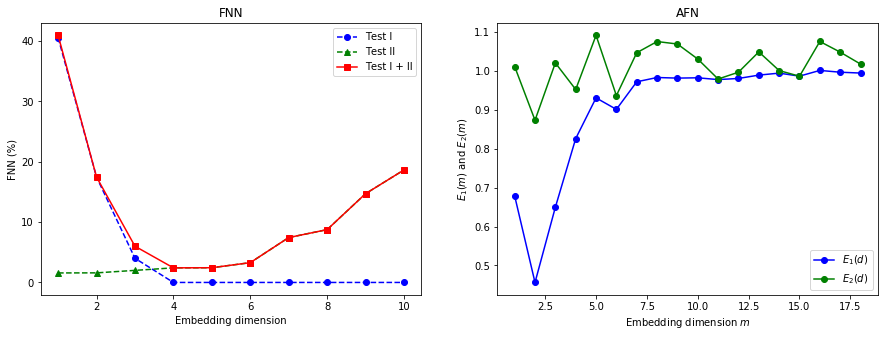

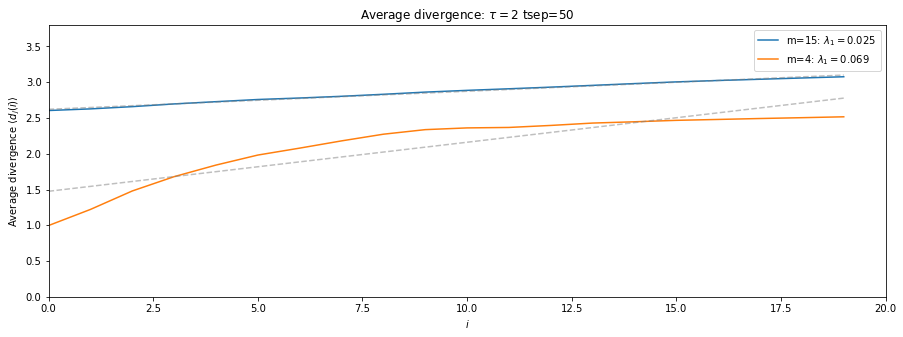

CHANNEL 2


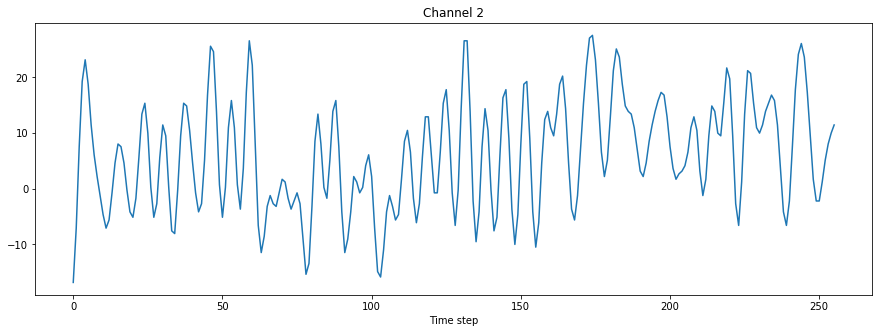

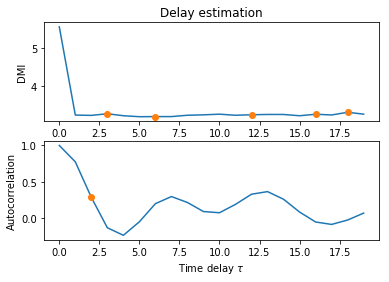

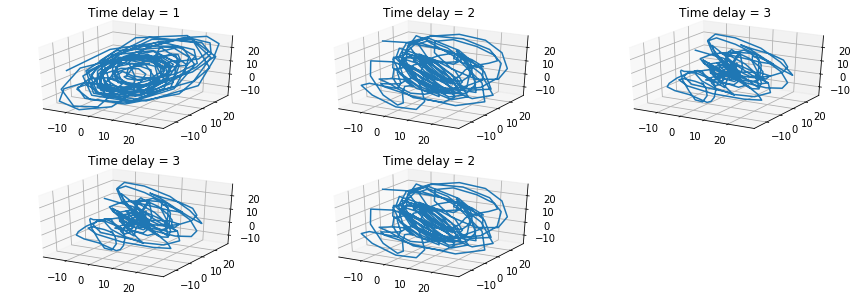

$\tau=1$ tsep=50


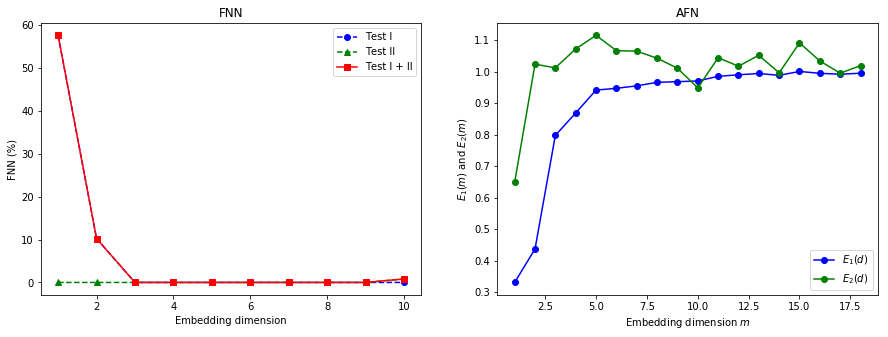

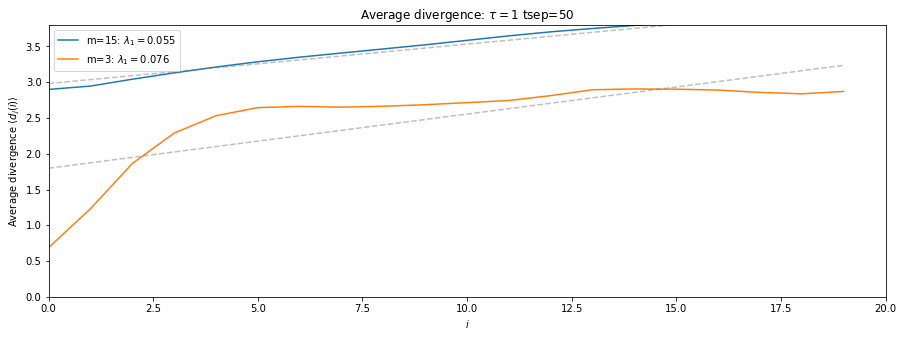

$\tau=2$ tsep=50


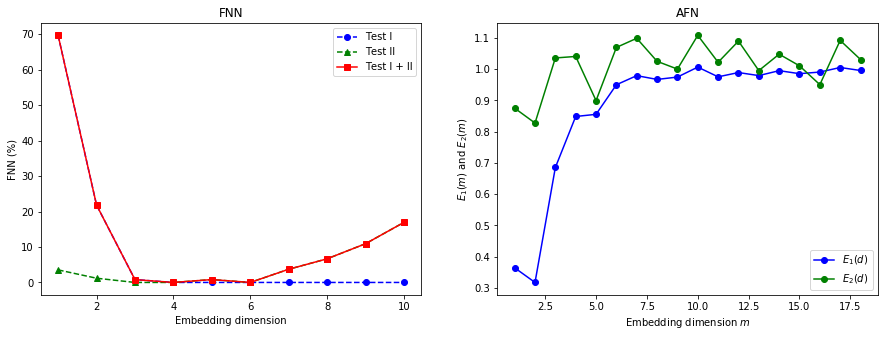

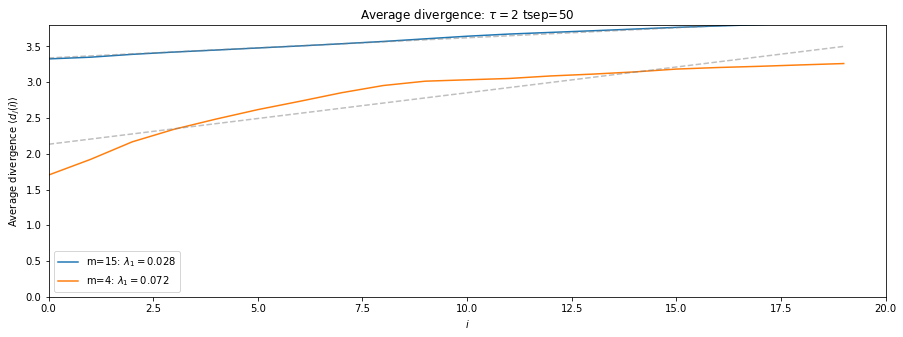

CHANNEL 3


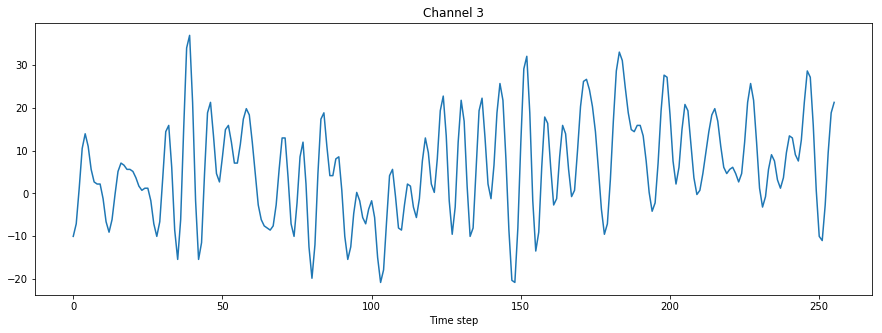

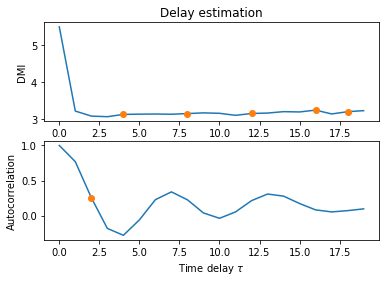

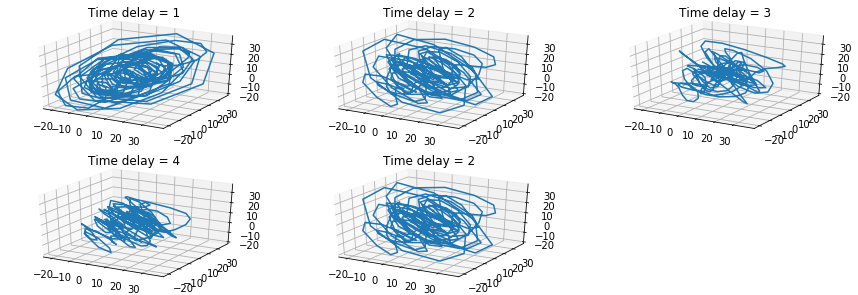

$\tau=1$ tsep=50


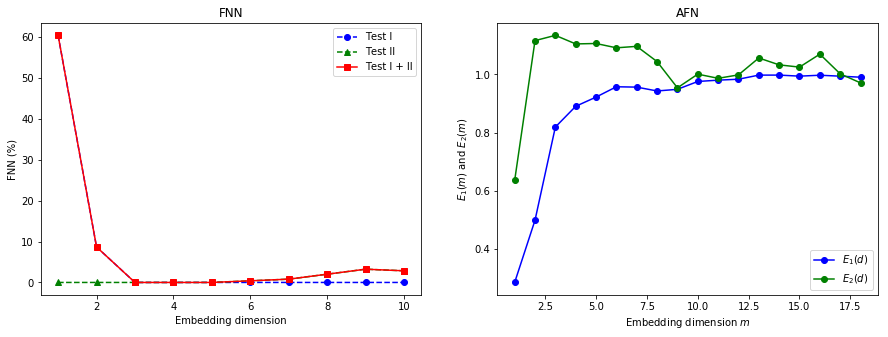

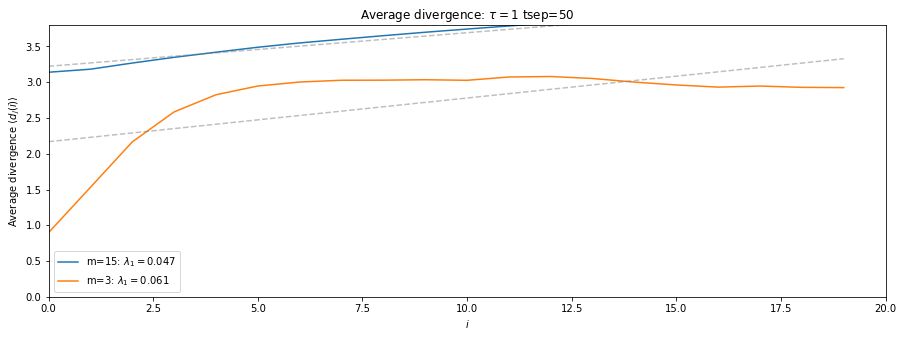

$\tau=2$ tsep=50


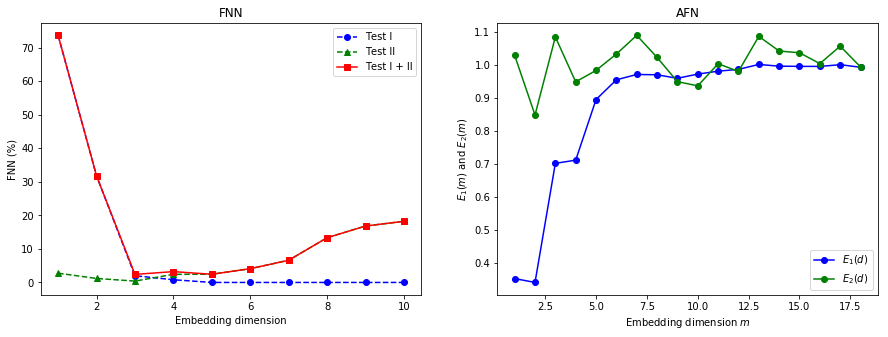

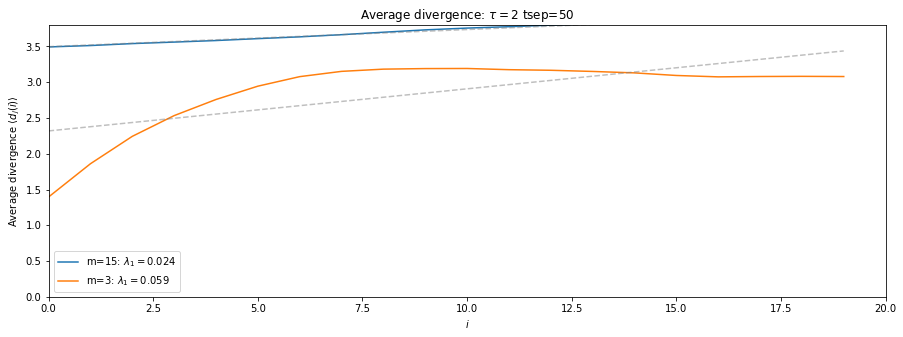

CHANNEL 4


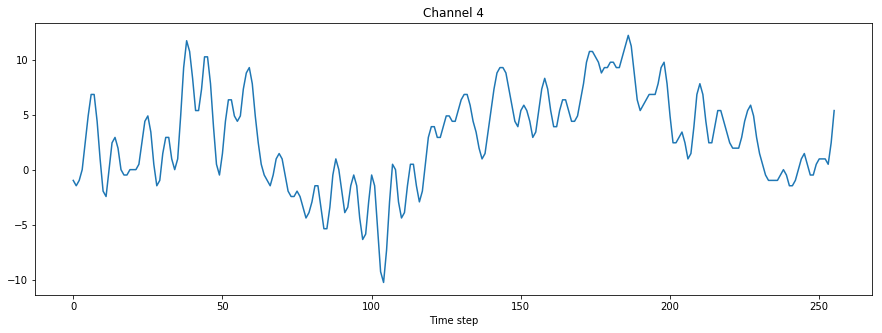

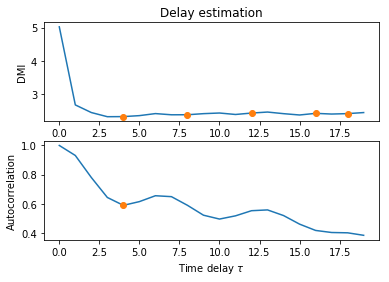

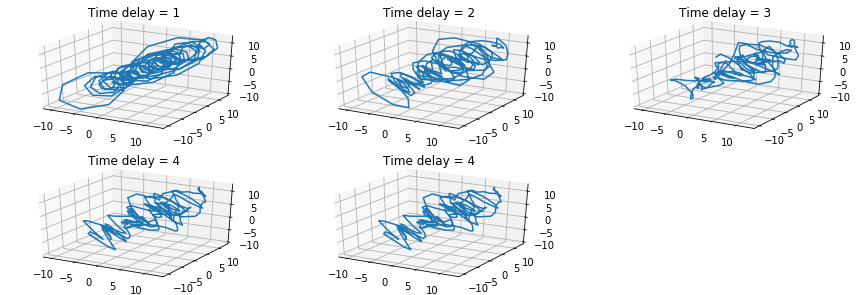

$\tau=1$ tsep=50


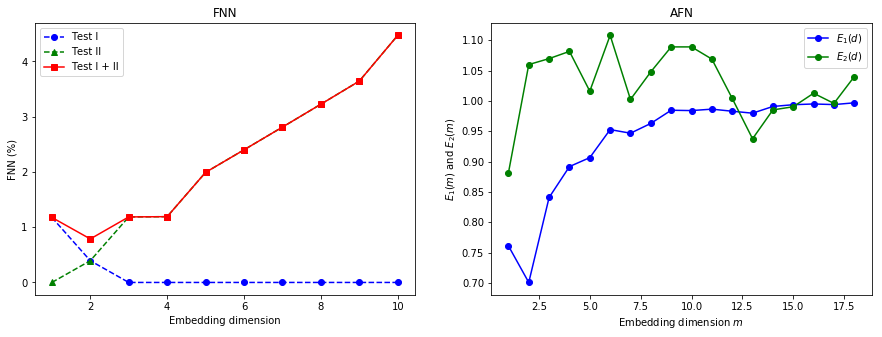

/home/kovar/thesis_project/src/lib/nolitsa/nolitsa/lyapunov.py:75: RuntimeWarning: divide by zero encountered in log
  d[t] = np.mean(np.log(utils.dist(y[t1], y[t2], metric=metric)))


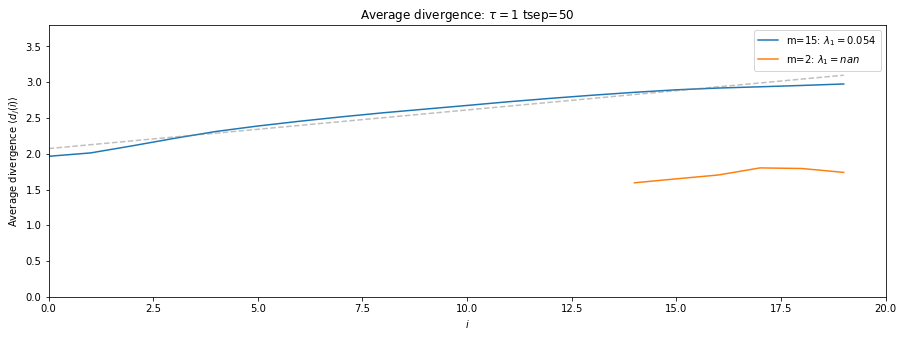

$\tau=4$ tsep=50


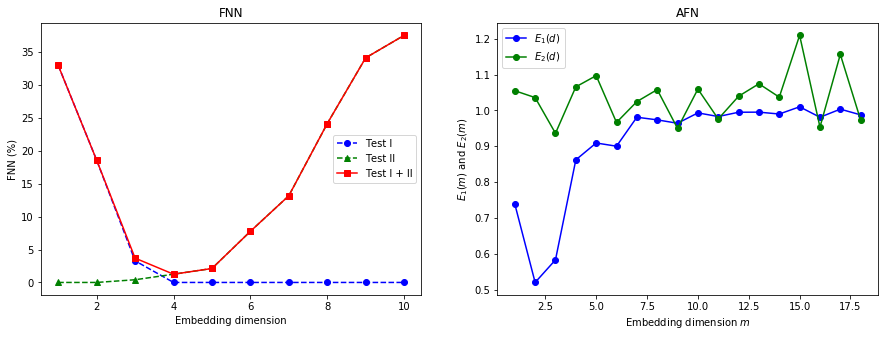

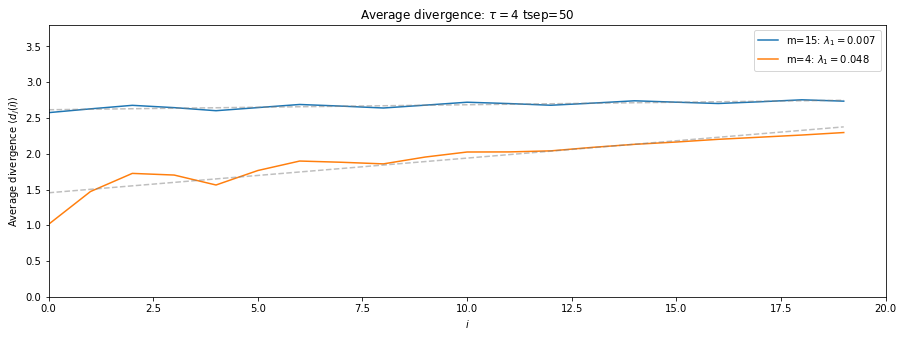

CHANNEL 5


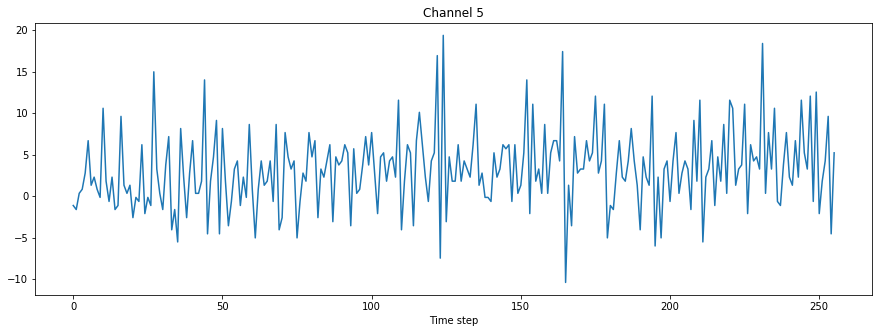

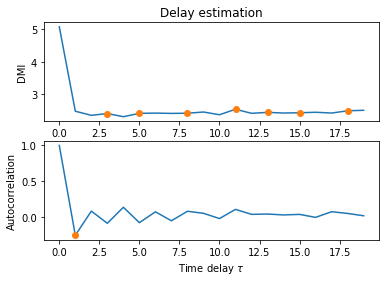

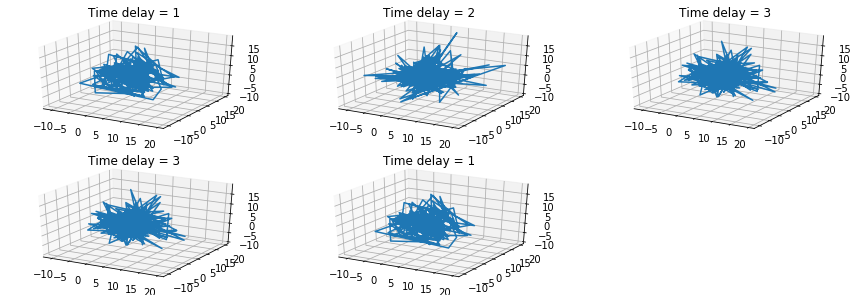

$\tau=1$ tsep=50


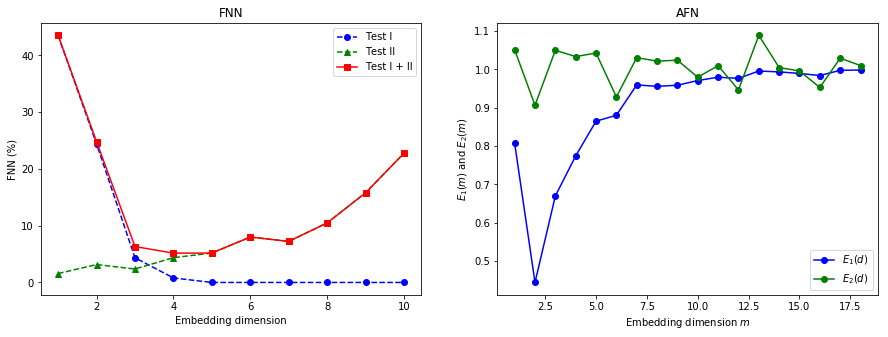

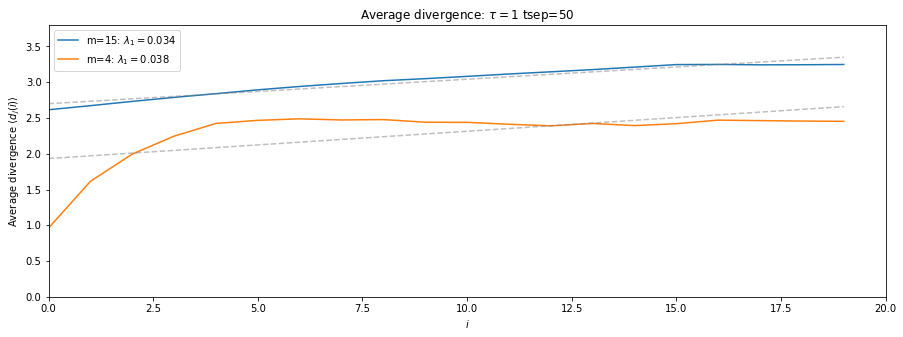

$\tau=1$ tsep=50


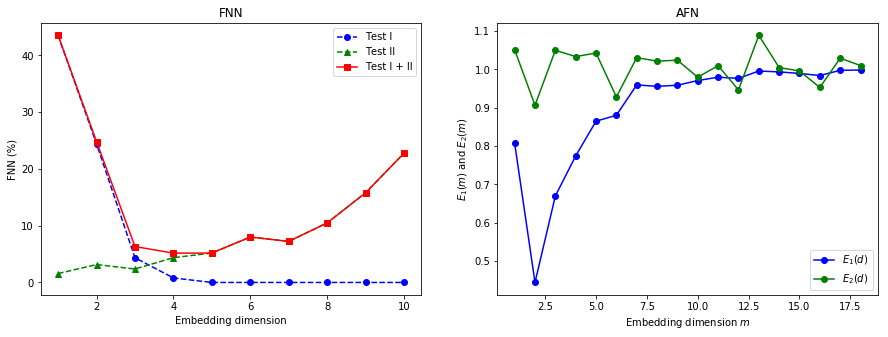

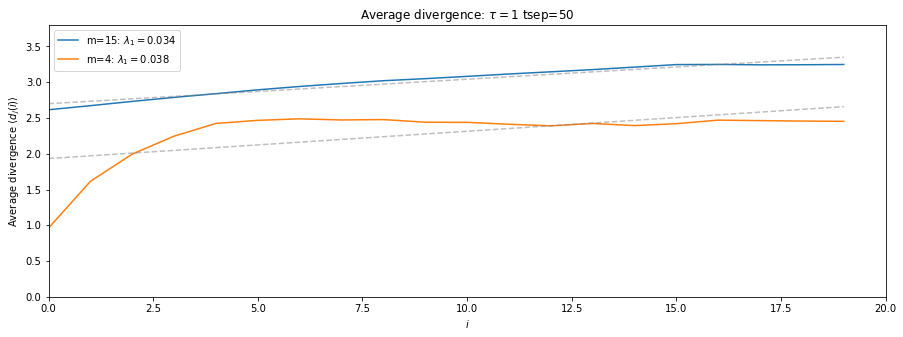

CHANNEL 6


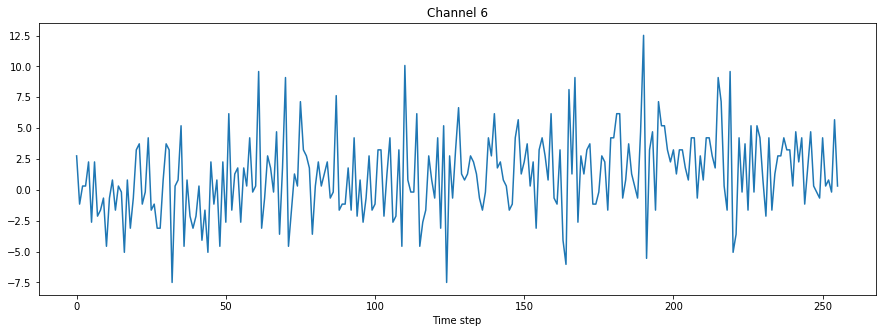

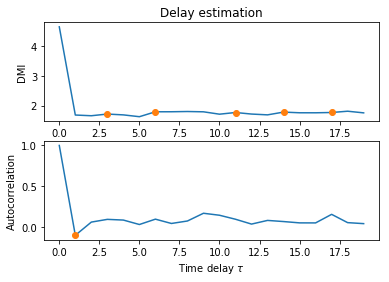

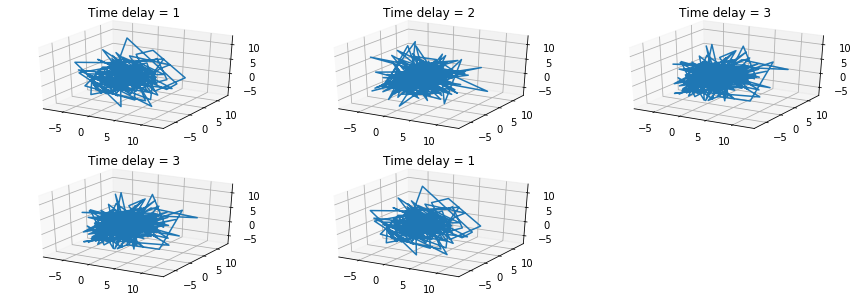

$\tau=1$ tsep=50


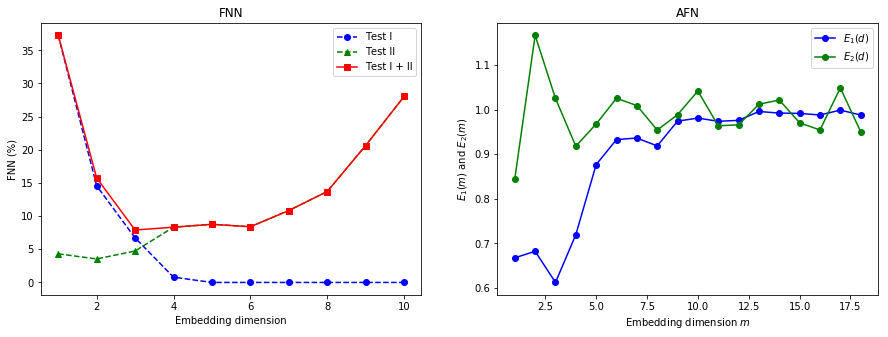

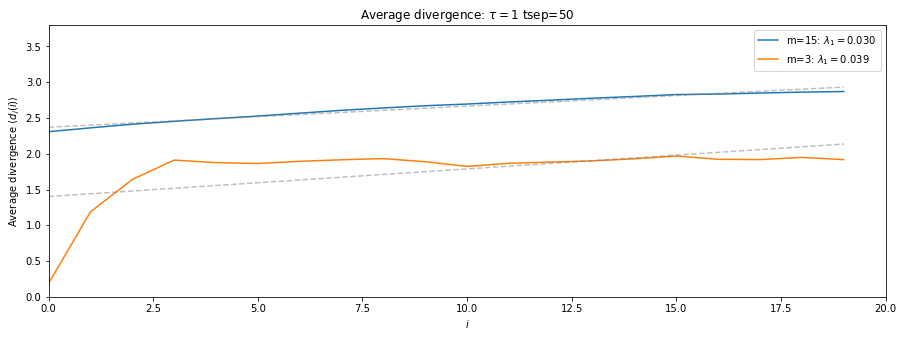

$\tau=1$ tsep=50


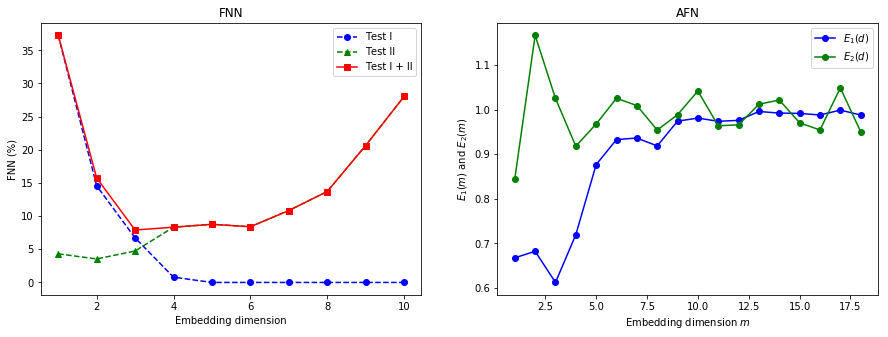

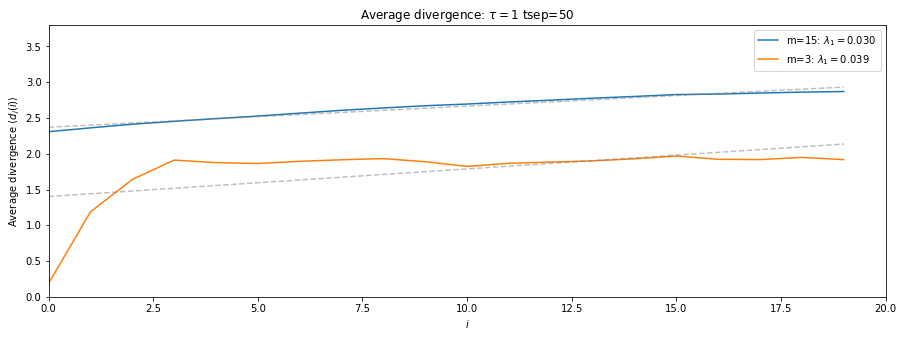

CHANNEL 7


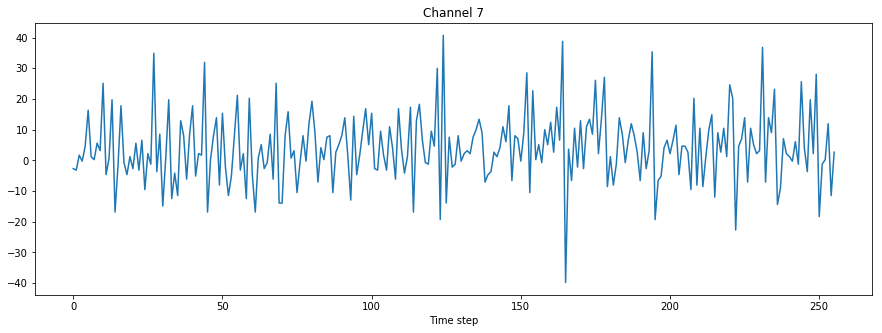

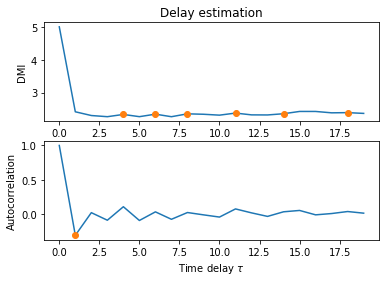

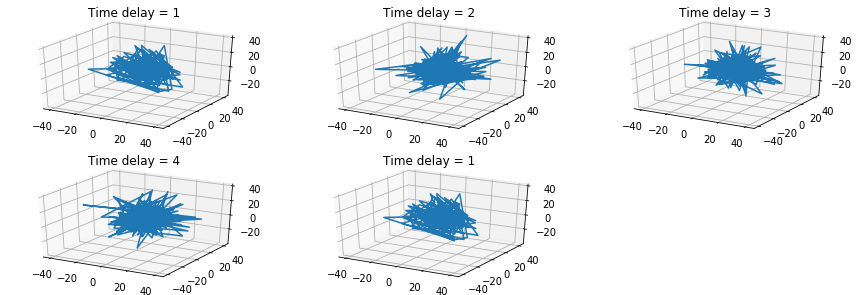

$\tau=1$ tsep=50


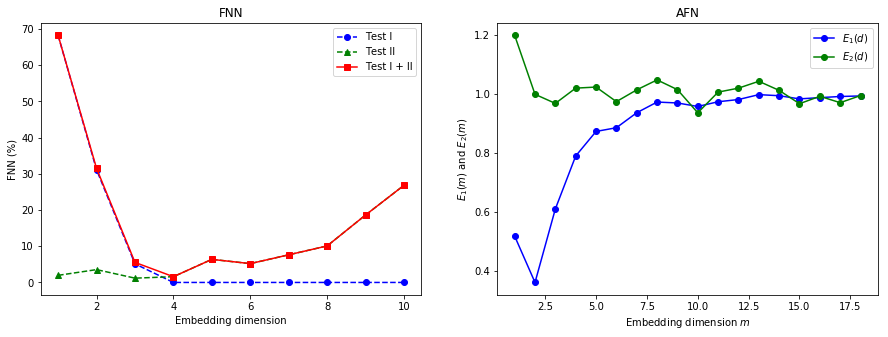

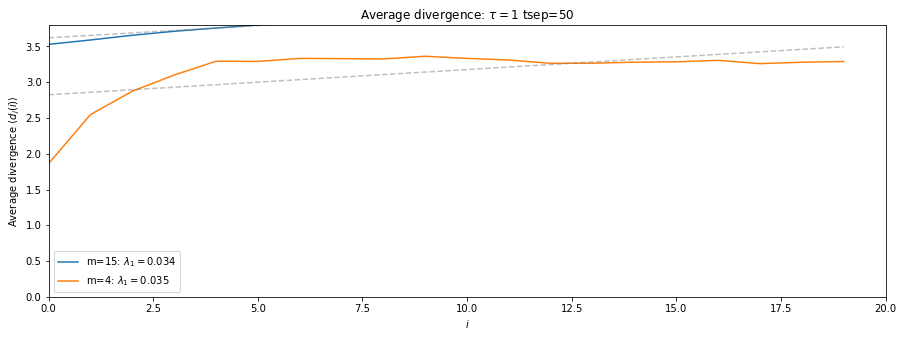

$\tau=1$ tsep=50


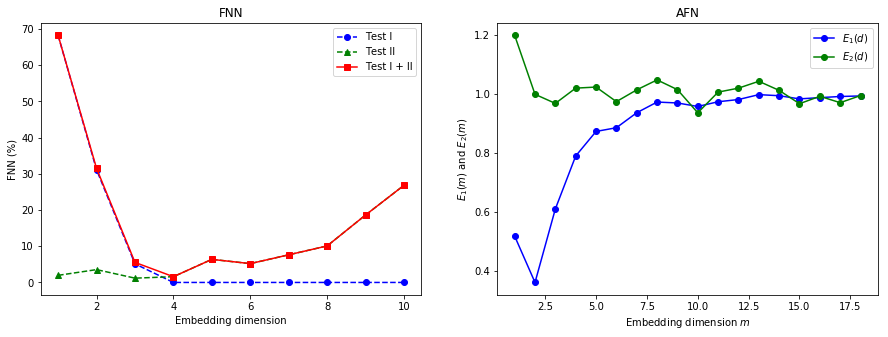

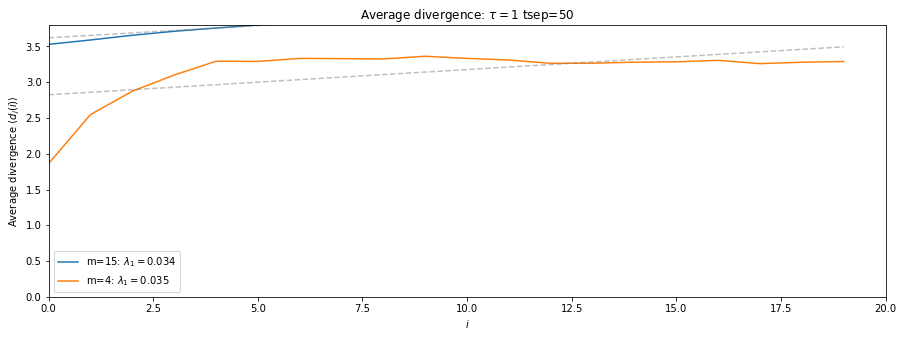

CHANNEL 8


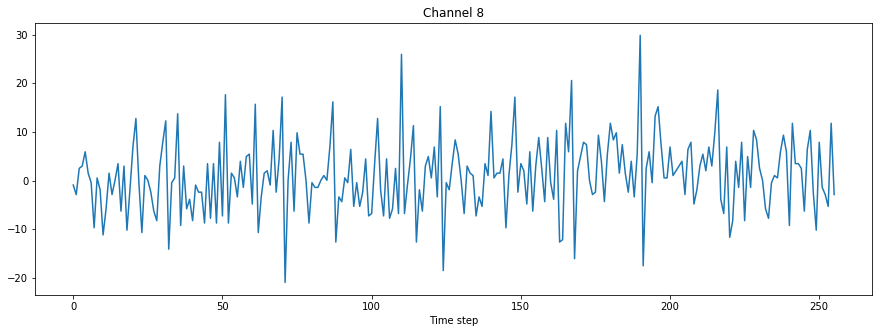

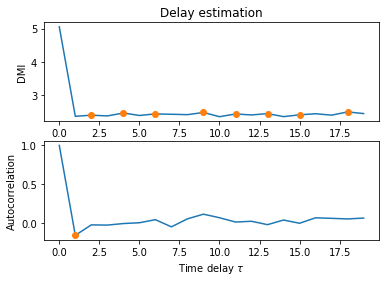

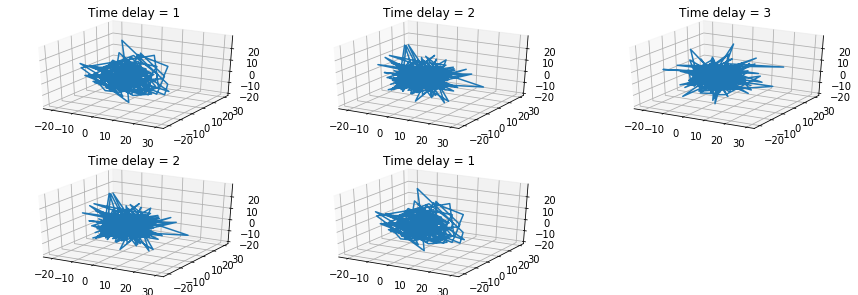

$\tau=1$ tsep=50


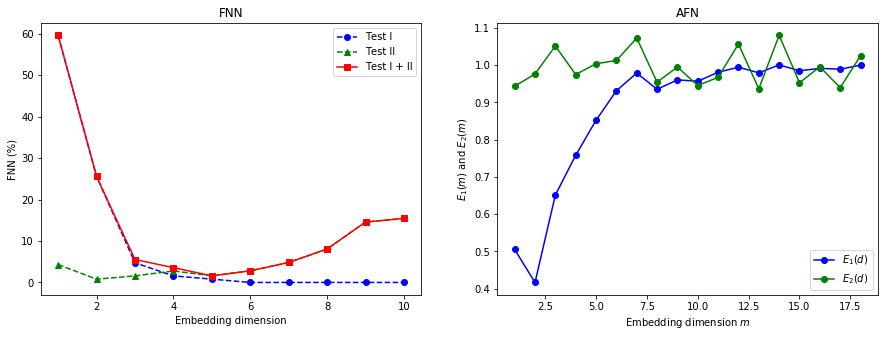

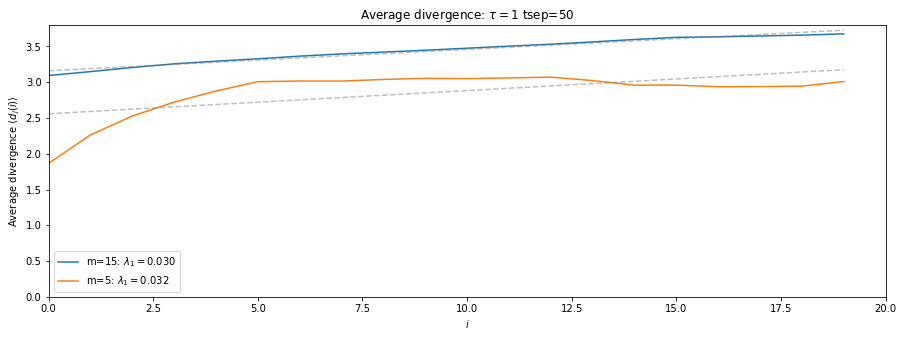

$\tau=1$ tsep=50


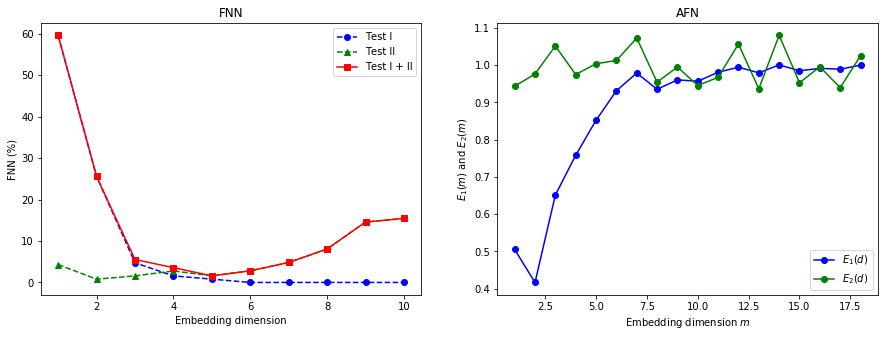

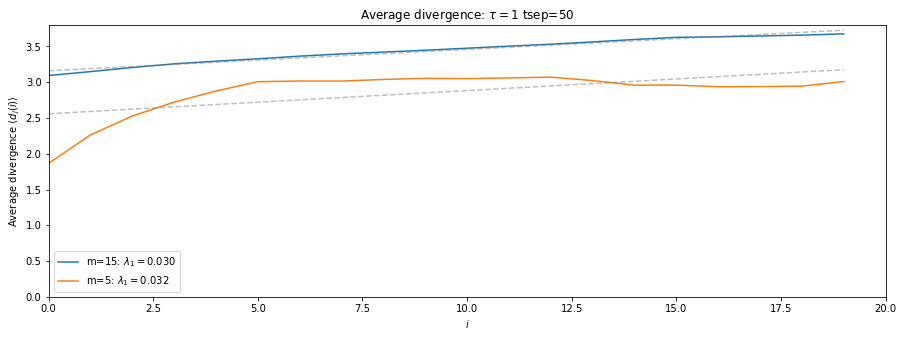

CHANNEL 9


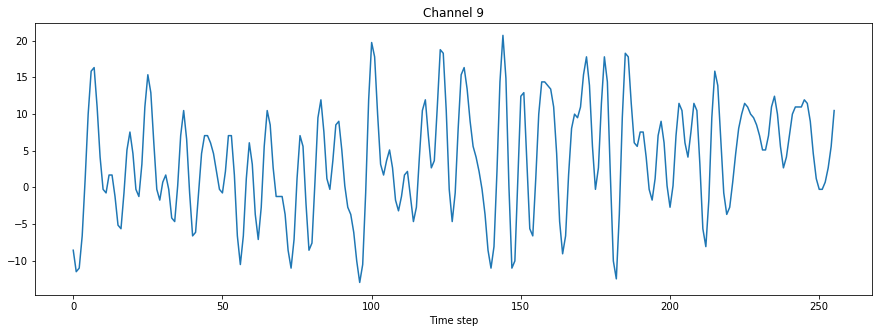

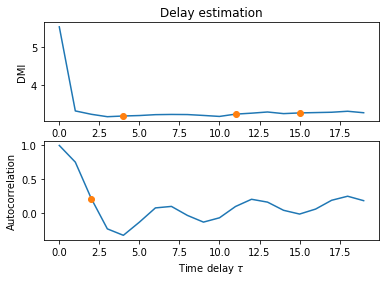

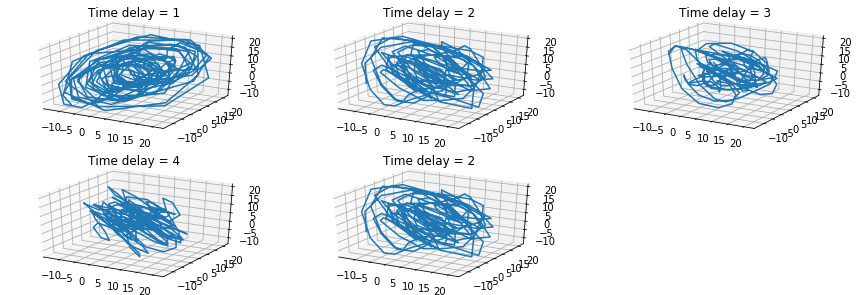

$\tau=1$ tsep=50


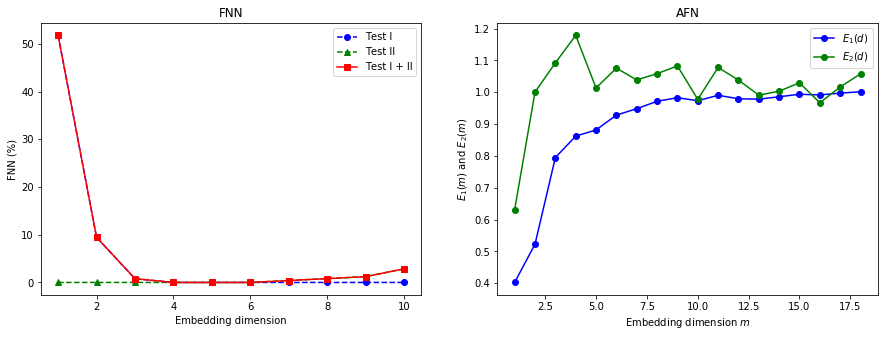

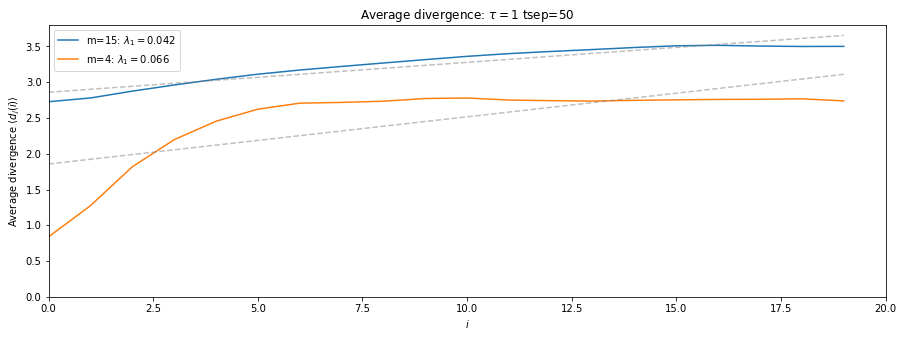

$\tau=2$ tsep=50


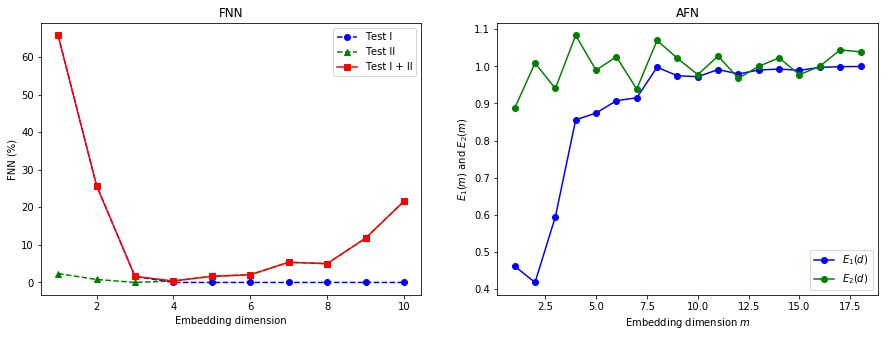

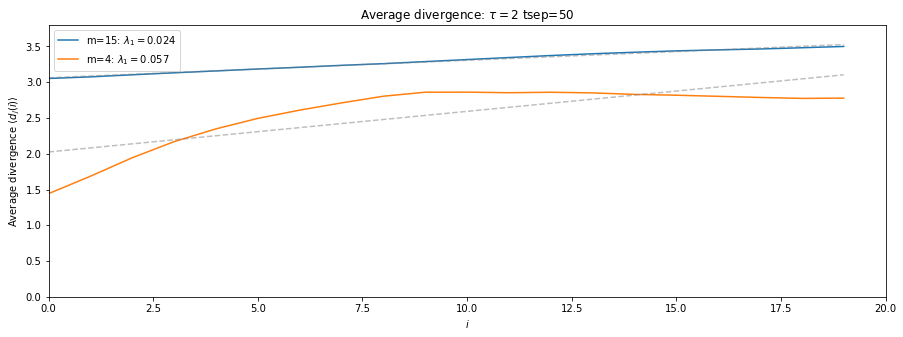

CHANNEL 10


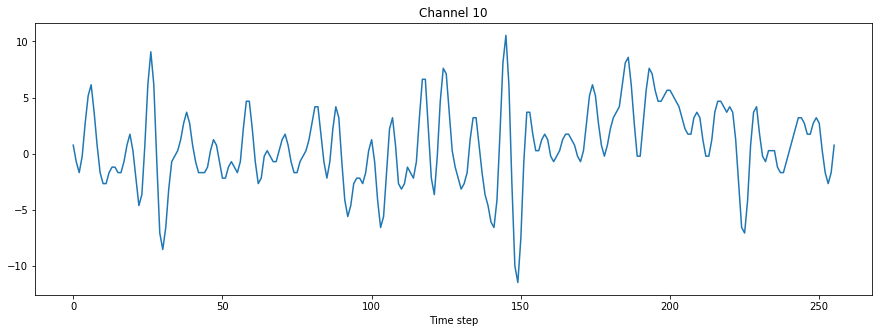

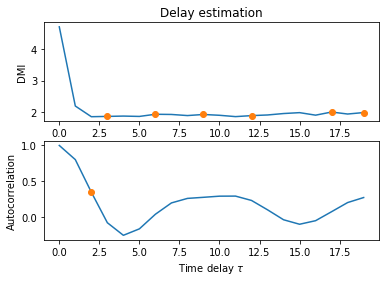

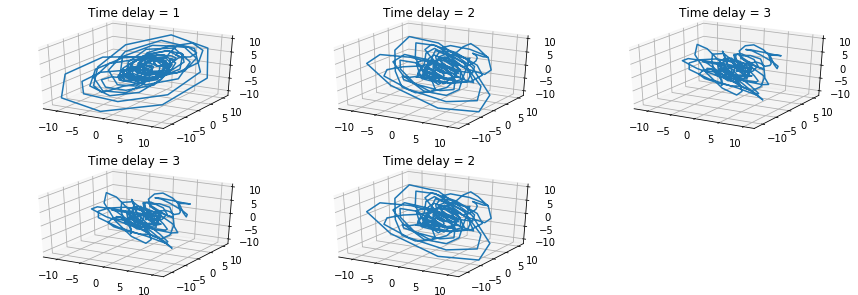

$\tau=1$ tsep=50


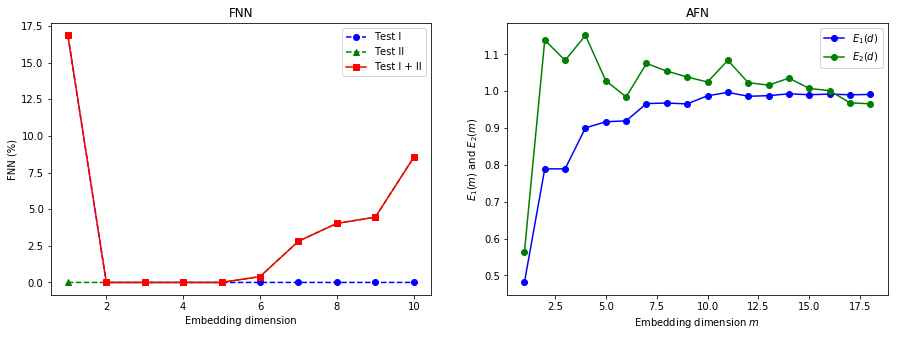

/home/kovar/thesis_project/src/lib/nolitsa/nolitsa/lyapunov.py:75: RuntimeWarning: divide by zero encountered in log
  d[t] = np.mean(np.log(utils.dist(y[t1], y[t2], metric=metric)))


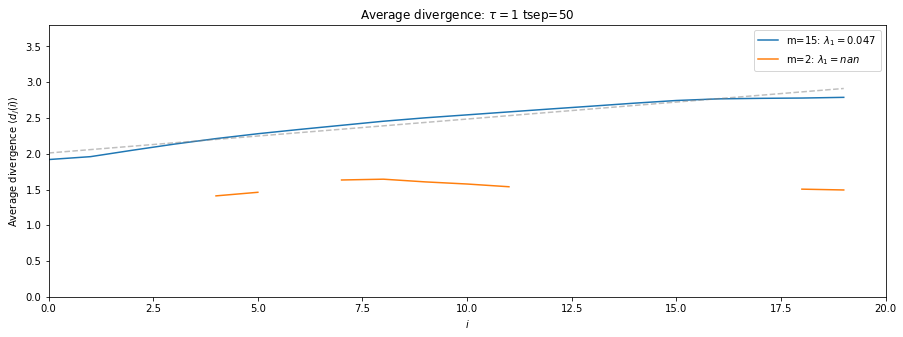

$\tau=2$ tsep=50


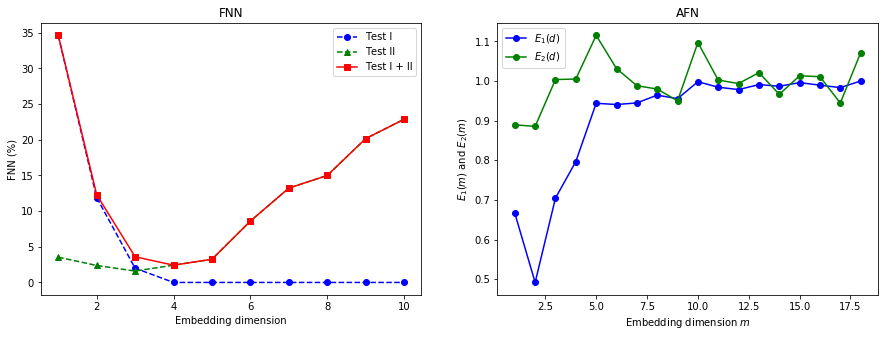

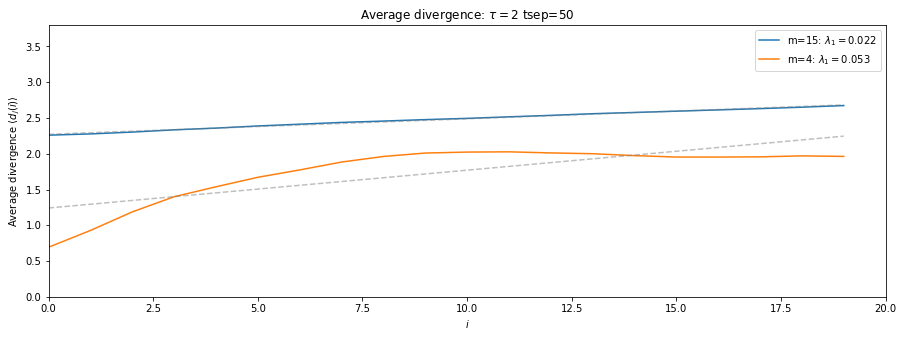

CHANNEL 11


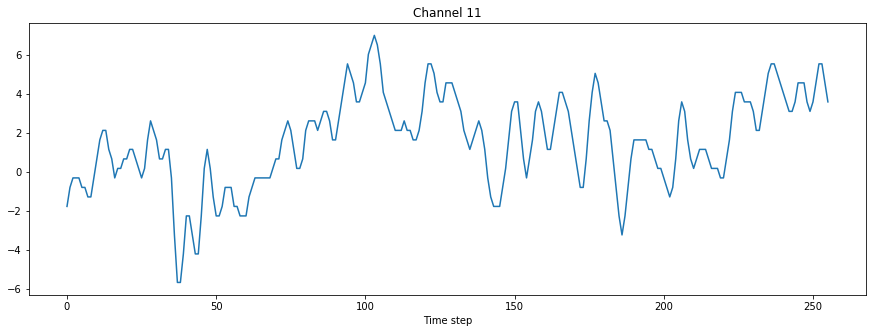

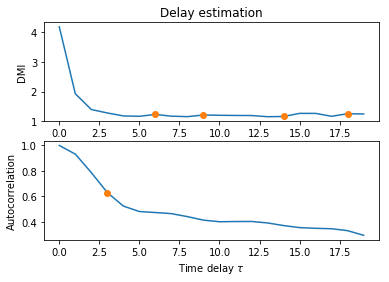

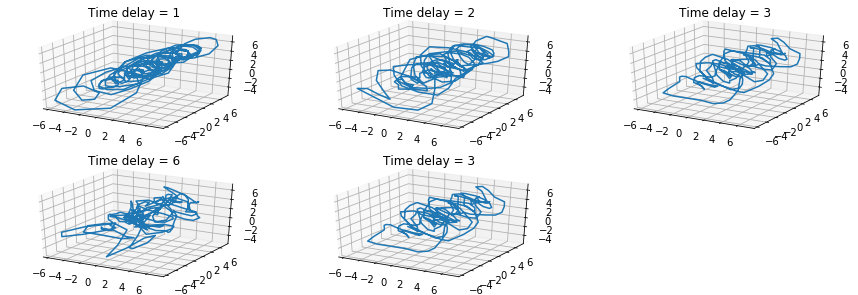

$\tau=1$ tsep=50


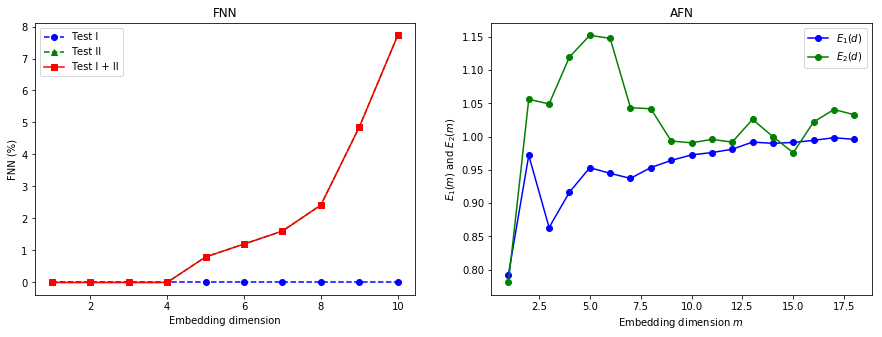

Exception: Could not find any near neighbor with a nonzero distance.  Try increasing the value of maxnum.

In [51]:
taus = [1]
dims = [15]
windows = [50]
maxt = 20
maxtau = 20
# sampl_period = 1/250
sampl_period = 1
R = 10.0
A = 3.0

plot(alc_eeg_signals)